# Lab 3 - Pitfalls of retrieval: When simple vector search fails!

In [2]:
# This cell is the same as Lab 1 till we create the collection collapsed into a single block

import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

from pypdf import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

reader = PdfReader("The-Mom-Test-en.pdf")

pdf_texts = [p.extract_text().strip() for p in reader.pages]

pdf_texts = [text for text in pdf_texts if text]  # Filter the empty strings

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)
   

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_client = chromadb.Client()

chroma_collection = chroma_client.create_collection("TheMomTest_book", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)

chroma_collection.count()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


236

In [4]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/Users/damiangarayalde/Desktop/Work - Github Repos/AI/Advanced Retrieval for AI with Chroma/env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [6]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 236/236 [01:00<00:00,  3.87it/s]


(1.3934171438217162, 7.895477032661438, 9.91193323135376, 16.56757230758667)

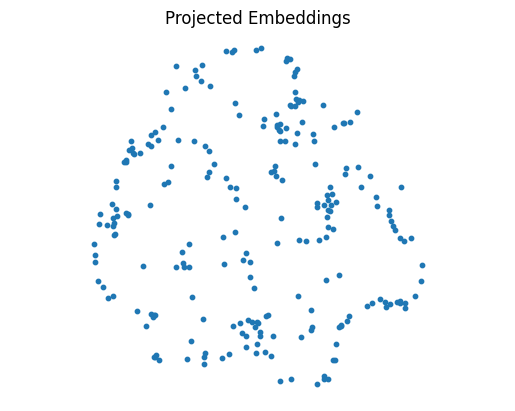

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

## Relevancy and Distraction

In [18]:
query = "How to test an idea?"

query_embedding = embedding_function([query])[0]

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents  = results['documents'][0]
retrieved_embeddings = results['embeddings'][0]

# for document in results['documents'][0]:
#     print(document)
#     print('')

In [19]:
projected_query_embedding      = project_embeddings([query_embedding],    umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:01<00:00,  4.09it/s]


(1.3934171438217162, 7.895477032661438, 9.91193323135376, 16.56757230758667)

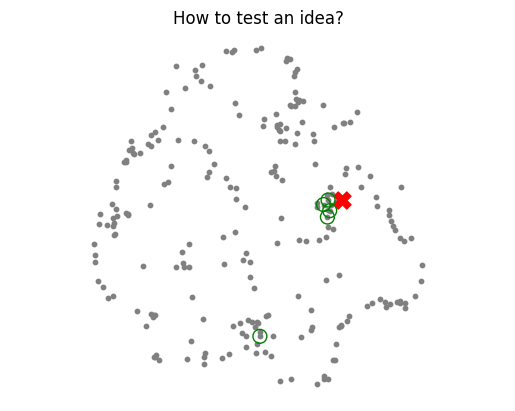

In [20]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [21]:
query = "What is the role of pikachu in Attack on Titan?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

facts — concrete, specific facts about what they do and why they do it 117

one of our alpha users and to roll it out to some subset of their team and be a case study for launch. if i ’ ve hit on a real problem, he ’ ll jump at the chance to start making progress today and get early access. 68

“ what do we want to learn from these guys? ” in fact, if you ’ re tight for time, asking this question is the only prep you really need. rule of thumb : if you don ’ t know what you ’ re trying to learn, you shouldn ’ t bother having the conversation. 102

to solve the petty annoyances of their day.

“ oh, you know. read the news, play sudoku, catch up with my friends. the usual. ” son : “ what ’ s the last thing you did on it? ” get specific about examples in the past to get real, concrete data. mom : “ you know your father and i are planning that trip? i was figuring out where we could stay. “ she uses it for both entertainment and utility, which didn ’ t come up during the “ usually ” answer

In [22]:
query_embedding      = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding      = project_embeddings([query_embedding],    umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


(1.3934171438217162, 7.895477032661438, 9.91193323135376, 16.56757230758667)

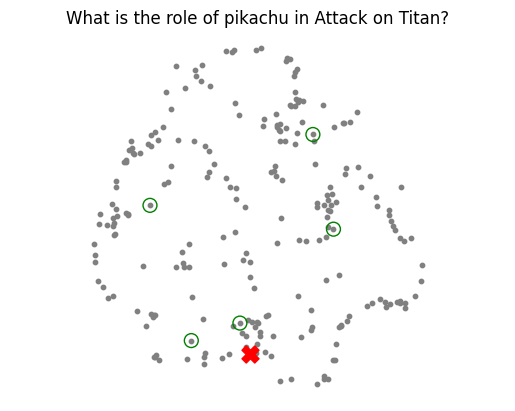

In [23]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[  :, 0], projected_dataset_embeddings[  :, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[     :, 0], projected_query_embedding[     :, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [24]:
query = "How to ask good questions?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

fix them. 14 good question / bad question let ’ s play a game. are the following questions good or bad? do they pass or fail the mom test? if they fail it, why? and how could we improve them? work your way through the list and then read on for some discussion. “ do you think it ’ s a good idea? ” “ would you buy a product which did x? ” “ how much would you pay for x? ” “ what would your dream product do? ” “ why do you bother? ” “ what are the implications of that? ” “ talk me through the last time that happened. ” “ talk me through your workflow. ” “ what else have you tried? ” “ would you pay x for a product which did y? ” “ how are you dealing with it now? ” “ where does the money come from? ” “ who else should i talk to? ” “ is there anything else i should have asked? ” 15

prepare your list of 3 always pre - plan the 3 most important things you want to learn from any given type of person. pre - planning your big questions makes it a lot easier to ask questions which pass the mom 

In [25]:
query_embedding      = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding      = project_embeddings([query_embedding],   umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  4.25it/s]


(1.3934171438217162, 7.895477032661438, 9.91193323135376, 16.56757230758667)

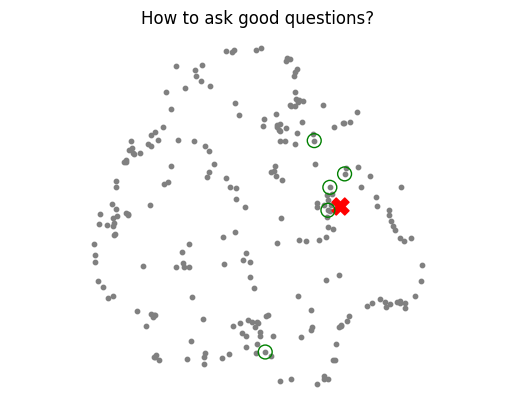

In [26]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')